# Xgboost Modeling 

### Selecting Optimal Value of Logloss to train the final model 

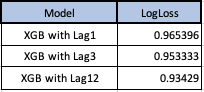

In [1]:
from IPython.display import display, Image

display(Image(filename='/Users/gaurav/Documents/Xgboost Logloss.png'))

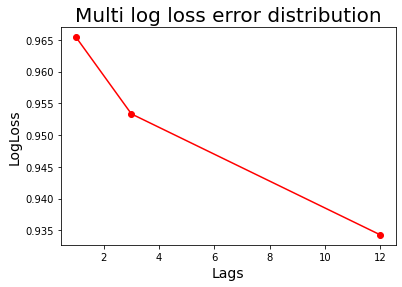

In [2]:
import matplotlib.pyplot as plt
   
Lag = [1,3,12]
LogLoss = [0.965396, 0.953333, 0.93429]
  
plt.plot(Lag, LogLoss, color='red', marker='o')
plt.title('Multi log loss error distribution', fontsize=20)
plt.xlabel('Lags', fontsize=14)
plt.ylabel('LogLoss', fontsize=14)
plt.show()

In order to find the month which gives the best prediction, three directions of month selection are performed by combining the previous month’s product information as input features such as: using the previous month to predict the current month, using the month from last year to predict the same month of current year, using one month to predict the situation of three months later. Also, it is found that the best way in this dataset to recommend new products is based on the same month from the previous year. Since then, the data of June, 2015 is used as the train set to give the recommendation for June, 2016. 

## Function to calculate MAP@7

In [86]:
import numpy as np
import pandas as pd
import xgboost as xgb

def apk(actual, predicted, k=7, default=0.0):
    # Since it is MAP@7, use up to 7
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        # Conditions for giving points are as follows:
        # The predicted value is in the correct answer ('p in actual')
        # If the predicted value is not duplicate ('p not in predicted[:i]')
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    # If the correct answer value is blank, 0.0 is unconditionally returned.
    if not actual:
        return default

    # Calculate the average precision by the number of correct answers (len(actual))
    return score / min(len(actual), k)

def mapk(actual, predicted, k=7, default=0.0):
    # Calculate the Average Precision for each customer from the list of list, 
    #actual and predicted values, and calculate the average through np.mean()
    return np.mean([apk(a, p, k, default) for a, p in zip(actual, predicted)]) 

In [87]:
np.random.seed(2018)
# Load data.
trn = pd.read_csv('Train_Cleaned.csv')
tst = pd.read_csv('Test_Cleaned.csv')

/Users/gaurav/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [88]:
trn.head()

,Month_status_date,Customer_ID,Employee_Index,Customer_country,Sex,Age,Join_date,New_customer,Relnshp_Mnths,Relnshp_flag,Last_date_Prim_Cust,Cust_type_beg_Mth,Cust_Reln_type_beg_mth,Residence_flag,Forigner_flag,Emp_spouse_flag,Channel_when_joined,Deceased_flag,Address_detail,Activity_flag,Gross_household_income,Segment,Saving_account,Guarantees,Cur_account,Derivative_account,Payroll_account,Junior_account,Particular_acct1,Particular_acct2,Particular_acct3,Short_term_deposites,Med_term_deposites,Long_term_deposites,e-account,Funds,Mortgage,Pension,Loans,Taxes,Credit_card,Securities,Home_account,Payroll,Pensions,Direct_debit
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0,6,1,UNKNOWN,1,A,S,N,UNKNOWN,KHL,N,MALAGA,1,87218.10,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0,35,1,UNKNOWN,1,I,S,S,UNKNOWN,KHE,N,CIUDAD REAL,0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0,35,1,UNKNOWN,1,I,S,N,UNKNOWN,KHE,N,CIUDAD REAL,0,122179.11,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0,35,1,UNKNOWN,1,I,S,N,UNKNOWN,KHD,N,ZARAGOZA,0,119775.54,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0,35,1,UNKNOWN,1,A,S,N,UNKNOWN,KHE,N,ZARAGOZA,1,99950.28,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [89]:
trn.shape

(13647309, 46)

In [90]:
pd.set_option('display.max_columns', None)

In [91]:
## Data preprocessing ##

# Store product variables separately.
prods = trn.columns[22:].tolist()

In [92]:
prods

['Saving_account',
 'Guarantees',
 'Cur_account',
 'Derivative_account',
 'Payroll_account',
 'Junior_account',
 'Particular_acct1',
 'Particular_acct2',
 'Particular_acct3',
 'Short_term_deposites',
 'Med_term_deposites',
 'Long_term_deposites',
 'e-account',
 'Funds',
 'Mortgage',
 'Pension',
 'Loans',
 'Taxes',
 'Credit_card',
 'Securities',
 'Home_account',
 'Payroll',
 'Pensions',
 'Direct_debit']

In [93]:
trn.isnull().sum()

Month_status_date         0
Customer_ID               0
Employee_Index            0
Customer_country          0
Sex                       0
Age                       0
Join_date                 0
New_customer              0
Relnshp_Mnths             0
Relnshp_flag              0
Last_date_Prim_Cust       0
Cust_type_beg_Mth         0
Cust_Reln_type_beg_mth    0
Residence_flag            0
Forigner_flag             0
Emp_spouse_flag           0
Channel_when_joined       0
Deceased_flag             0
Address_detail            0
Activity_flag             0
Gross_household_income    0
Segment                   0
Saving_account            0
Guarantees                0
Cur_account               0
Derivative_account        0
Payroll_account           0
Junior_account            0
Particular_acct1          0
Particular_acct2          0
Particular_acct3          0
Short_term_deposites      0
Med_term_deposites        0
Long_term_deposites       0
e-account                 0
Funds               

In [94]:
# Replace missing values of product variables with 0 in advance.
#trn[prods] = trn[prods].fillna(0.0).astype(np.int8)

In [95]:
trn['Join_date'].unique()

array(['2015-01-12', '2012-08-10', '2011-09-06', ..., '2016-05-25',
       '2016-05-01', '2016-05-15'], dtype=object)

In [96]:
# Remove customer data that doesn't have any of the 24 products.
no_product = trn[prods].sum(axis=1) == 0
trn = trn[~no_product]

In [97]:
trn.shape

(11091070, 46)

In [98]:
tst["Customer_ID"].nunique()

929615

In [99]:
tst.shape

(929615, 22)

In [100]:
tst.Month_status_date.unique()

array(['2016-06-28'], dtype=object)

In [101]:
# Integrate training data and test data. 
#Product variables that are not in the test data are filled with zeros.
for col in trn.columns[24:]:
    tst[col] = 0
df = pd.concat([trn, tst], axis=0)

In [102]:
df.drop(['Last_date_Prim_Cust','Emp_spouse_flag'], axis = 1, inplace=True)

In [103]:
df.drop(['Saving_account','Guarantees'], axis = 1, inplace=True)

In [104]:
len(df['Join_date'].unique())

6756

In [105]:
df.head(10)

,Month_status_date,Customer_ID,Employee_Index,Customer_country,Sex,Age,Join_date,New_customer,Relnshp_Mnths,Relnshp_flag,Cust_type_beg_Mth,Cust_Reln_type_beg_mth,Residence_flag,Forigner_flag,Channel_when_joined,Deceased_flag,Address_detail,Activity_flag,Gross_household_income,Segment,Cur_account,Derivative_account,Payroll_account,Junior_account,Particular_acct1,Particular_acct2,Particular_acct3,Short_term_deposites,Med_term_deposites,Long_term_deposites,e-account,Funds,Mortgage,Pension,Loans,Taxes,Credit_card,Securities,Home_account,Payroll,Pensions,Direct_debit
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0,6,1,1,A,S,N,KHL,N,MALAGA,1,87218.10,02 - PARTICULARES,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0,35,1,1,I,S,S,KHE,N,CIUDAD REAL,0,35548.74,03 - UNIVERSITARIO,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0,35,1,1,I,S,N,KHE,N,CIUDAD REAL,0,122179.11,03 - UNIVERSITARIO,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0,35,1,1,I,S,N,KHD,N,ZARAGOZA,0,119775.54,03 - UNIVERSITARIO,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0,35,1,1,A,S,N,KHE,N,ZARAGOZA,1,99950.28,03 - UNIVERSITARIO,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2015-01-28,1050615,N,ES,H,23,2012-08-10,0,35,1,1,I,S,N,KHE,N,TOLEDO,0,22220.04,03 - UNIVERSITARIO,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,2015-01-28,1050616,N,ES,H,23,2012-08-10,0,35,1,1,I,S,N,KHE,N,LEON,0,295590.36,03 - UNIVERSITARIO,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,2015-01-28,1050617,N,ES,H,23,2012-08-10,0,35,1,1,A,S,N,KHE,N,ZARAGOZA,1,113316.66,03 - UNIVERSITARIO,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,2015-01-28,1050619,N,ES,H,24,2012-08-10,0,35,1,1,I,S,N,KHE,N,GIPUZKOA,0,80599.14,03 - UNIVERSITARIO,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,2015-01-28,1050620,N,ES,H,23,2012-08-10,0,35,1,1,I,S,N,KHE,N,CACERES,0,113194.98,03 - UNIVERSITARIO,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [106]:
df[df['Customer_ID'] == 1375586]

,Month_status_date,Customer_ID,Employee_Index,Customer_country,Sex,Age,Join_date,New_customer,Relnshp_Mnths,Relnshp_flag,Cust_type_beg_Mth,Cust_Reln_type_beg_mth,Residence_flag,Forigner_flag,Channel_when_joined,Deceased_flag,Address_detail,Activity_flag,Gross_household_income,Segment,Cur_account,Derivative_account,Payroll_account,Junior_account,Particular_acct1,Particular_acct2,Particular_acct3,Short_term_deposites,Med_term_deposites,Long_term_deposites,e-account,Funds,Mortgage,Pension,Loans,Taxes,Credit_card,Securities,Home_account,Payroll,Pensions,Direct_debit
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0,6,1,1,A,S,N,KHL,N,MALAGA,1,87218.1,02 - PARTICULARES,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1047196,2015-02-28,1375586,N,ES,H,35,2015-01-12,0,6,1,1,A,S,N,KHL,N,MALAGA,1,87218.1,02 - PARTICULARES,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1681276,2015-03-28,1375586,N,ES,H,35,2015-01-12,0,6,1,1,A,S,N,KHL,N,MALAGA,1,87218.1,02 - PARTICULARES,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2299297,2015-04-28,1375586,N,ES,H,35,2015-01-12,0,6,1,1,A,S,N,KHL,N,MALAGA,1,87218.1,02 - PARTICULARES,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2714121,2015-05-28,1375586,N,ES,H,35,2015-01-12,0,6,1,1,A,S,N,KHL,N,MALAGA,1,87218.1,02 - PARTICULARES,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3343336,2015-06-28,1375586,N,ES,H,35,2015-01-12,0,6,1,1,A,S,N,KHL,N,MALAGA,1,87218.1,02 - PARTICULARES,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4581564,2015-07-28,1375586,N,ES,H,35,2015-01-12,0,6,1,1,A,S,N,KHL,N,MALAGA,1,87218.1,02 - PARTICULARES,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5075380,2015-08-28,1375586,N,ES,H,36,2015-01-12,0,7,1,1,A,S,N,KHL,N,MALAGA,0,87218.1,02 - PARTICULARES,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6258167,2015-09-28,1375586,N,ES,H,36,2015-01-12,0,8,1,1,I,S,N,KHL,N,MALAGA,0,87218.1,02 - PARTICULARES,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6572487,2015-10-28,1375586,N,ES,H,36,2015-01-12,0,9,1,1,I,S,N,KHL,N,MALAGA,0,87218.1,02 - PARTICULARES,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [107]:
df[df['Customer_ID'] == 658229]

,Month_status_date,Customer_ID,Employee_Index,Customer_country,Sex,Age,Join_date,New_customer,Relnshp_Mnths,Relnshp_flag,Cust_type_beg_Mth,Cust_Reln_type_beg_mth,Residence_flag,Forigner_flag,Channel_when_joined,Deceased_flag,Address_detail,Activity_flag,Gross_household_income,Segment,Cur_account,Derivative_account,Payroll_account,Junior_account,Particular_acct1,Particular_acct2,Particular_acct3,Short_term_deposites,Med_term_deposites,Long_term_deposites,e-account,Funds,Mortgage,Pension,Loans,Taxes,Credit_card,Securities,Home_account,Payroll,Pensions,Direct_debit
507732,2015-01-28,658229,N,ES,V,33,2006-11-20,0,104,1,1,A,S,N,KFC,N,SEVILLA,1,115696.41,03 - UNIVERSITARIO,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
746776,2015-02-28,658229,N,ES,V,33,2006-11-20,0,104,1,1,A,S,N,KFC,N,SEVILLA,1,115696.41,03 - UNIVERSITARIO,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1390338,2015-03-28,658229,N,ES,V,33,2006-11-20,0,104,1,1,A,S,N,KFC,N,SEVILLA,1,115696.41,03 - UNIVERSITARIO,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2002953,2015-04-28,658229,N,ES,V,33,2006-11-20,0,104,1,1,A,S,N,KFC,N,SEVILLA,1,115696.41,03 - UNIVERSITARIO,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3009480,2015-05-28,658229,N,ES,V,33,2006-11-20,0,104,1,1,A,S,N,KFC,N,SEVILLA,1,115696.41,03 - UNIVERSITARIO,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
3641162,2015-06-28,658229,N,ES,V,33,2006-11-20,0,104,1,1,A,S,N,KFC,N,SEVILLA,1,115696.41,03 - UNIVERSITARIO,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
3785633,2015-07-28,658229,N,ES,V,33,2006-11-20,0,104,1,1,A,S,N,KFC,N,SEVILLA,1,115696.41,03 - UNIVERSITARIO,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4912328,2015-08-28,658229,N,ES,V,33,2006-11-20,0,105,1,1,A,S,N,KFC,N,SEVILLA,1,115696.41,03 - UNIVERSITARIO,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5601110,2015-09-28,658229,N,ES,V,33,2006-11-20,0,106,1,1,A,S,N,KFC,N,SEVILLA,1,115696.41,03 - UNIVERSITARIO,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7163874,2015-10-28,658229,N,ES,V,33,2006-11-20,0,107,1,1,A,S,N,KFC,N,SEVILLA,1,115696.41,03 - UNIVERSITARIO,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1


In [108]:
# This is a list containing variables to be used for learning.
features = []

# Label-encode categorical variables through the .factorize() function.
categorical_cols = ['Employee_Index', 'Customer_country', 'Sex', 'Cust_Reln_type_beg_mth', 'Residence_flag',
                    'Forigner_flag', 'Channel_when_joined', 'Deceased_flag', 'Address_detail', 'Segment']
for col in categorical_cols:
    df[col], _ = df[col].factorize(na_sentinel=-99)
features += categorical_cols

In [109]:
features

['Employee_Index',
 'Customer_country',
 'Sex',
 'Cust_Reln_type_beg_mth',
 'Residence_flag',
 'Forigner_flag',
 'Channel_when_joined',
 'Deceased_flag',
 'Address_detail',
 'Segment']

In [110]:
df.shape

(12020685, 42)

In [111]:
df.loc[df.Relnshp_Mnths <0, "Relnshp_Mnths"] = 0

In [112]:
df['Relnshp_Mnths'].unique()

array([  6,  35,  34,   0,  33,  31,  21,  16,  27,   9,  22,  13,  29,
         8,  11,  10,  28,  24,   7,  25,  14,  12,  26,  23,   1,  18,
         4,   3,  17,  32,  20,  15,  30,  19, 157,  36,  40,  38,  37,
        39,   5,  47,  44,  42,  46,  45,  43,  41,  57,  48,  52,  49,
        50,  56,  58,  51,  55,  54,  53,  59,  62,  61,  60,  63,   2,
       139, 165, 118, 164,  94, 159, 143, 105, 151, 162, 137, 150, 128,
       122, 156, 119, 160,  79,  95, 132, 161,  98, 127,  72, 155, 108,
       163, 102, 148, 115, 146, 107,  81, 216, 135,  92, 121, 198, 134,
        93, 140, 110, 120, 147,  64,  77,  85,  99,  78, 100, 113, 154,
       166, 124, 141,  66, 117,  86, 193,  80, 144,  87, 126, 158, 101,
       116, 235,  88, 145, 103, 149, 109, 131,  97, 133,  68,  84, 232,
       125, 177, 112,  96,  69, 171, 142, 167, 104,  76,  82, 152,  70,
       138, 169,  65, 129, 190, 114, 111, 176, 153,  89, 136,  83, 123,
       187, 106, 231, 189, 217, 172, 199, 173, 174, 209, 180, 17

In [113]:
df['Cust_type_beg_Mth'].replace('P', 5, inplace=True)
df['Cust_type_beg_Mth'].replace('1', 1, inplace=True)
df['Cust_type_beg_Mth'].replace('2', 2, inplace=True)
df['Cust_type_beg_Mth'].replace('3', 3, inplace=True)
df['Cust_type_beg_Mth'].replace('4', 4, inplace=True)

In [114]:
df['Cust_type_beg_Mth'].unique()

array([1, 5, 3, 2, 4])

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12020685 entries, 0 to 929614
Data columns (total 42 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Month_status_date       object 
 1   Customer_ID             int64  
 2   Employee_Index          int64  
 3   Customer_country        int64  
 4   Sex                     int64  
 5   Age                     int64  
 6   Join_date               object 
 7   New_customer            int64  
 8   Relnshp_Mnths           int64  
 9   Relnshp_flag            int64  
 10  Cust_type_beg_Mth       int64  
 11  Cust_Reln_type_beg_mth  int64  
 12  Residence_flag          int64  
 13  Forigner_flag           int64  
 14  Channel_when_joined     int64  
 15  Deceased_flag           int64  
 16  Address_detail          int64  
 17  Activity_flag           int64  
 18  Gross_household_income  float64
 19  Segment                 int64  
 20  Cur_account             int64  
 21  Derivative_account      int64  

In [116]:
# Seek features for numeric variables to be used for learning.
features += ['Age','Relnshp_Mnths','Gross_household_income','New_customer','Relnshp_flag','Cust_type_beg_Mth','Activity_flag']


In [117]:
len(features)

17

In [118]:
features

['Employee_Index',
 'Customer_country',
 'Sex',
 'Cust_Reln_type_beg_mth',
 'Residence_flag',
 'Forigner_flag',
 'Channel_when_joined',
 'Deceased_flag',
 'Address_detail',
 'Segment',
 'Age',
 'Relnshp_Mnths',
 'Gross_household_income',
 'New_customer',
 'Relnshp_flag',
 'Cust_type_beg_Mth',
 'Activity_flag']

In the feature engineering stage, derived variables are created to be used for machine learning model training. In the baseline model, a total of 24 customer variables, 4 date-based derived variables, and 24 lag-1 variables are used.

The year and month information are extracted from fecha_alta, which means the date when the customer signed the first contract, and ult_fec_cli_1t, which means the date when the customer was last grade 1, respectively. In addition, there are various derived variables using date variables. For example, the difference between two date variables can be created as a derived variable.

Missing values ​​are temporarily replaced with -99. The machine learning model provided by Scikit-learn does not receive a missing value as an input value and an execution error occurs, but in the xgboost model, the missing value is also received as a normal input value. The missing data is recognized as one piece of information and used for model training, but I will set the missing value to -99.

In time series data, various derived variables can be created based on customer's past data. For example, whether a customer's age has changed in the last 3 months (i.e., has a birthday within 3 months) can be created as a binary variable, or information about a product purchased a month ago can be used as a variable, You can also calculate the average monthly salary for the last six months.

Starting from the conclusion, the lag variable indicating whether or not a financial product was held N months ago served as a good derivative. It is to use as current customer data whether it was held 1 month ago, 2 months ago, or 3 months ago for 24 financial product variables. In the baseline model, we will use the lag-1 to lag-5 variables that retrieve information from 1 month ago to 5 months ago.

In [119]:
# (Feature Engineering) Extract year and month information from two date variables.
df['Join_date_month'] = df['Join_date'].map(lambda x: 0.0 if x is float else float(x.split('-')[1])).astype(np.int8)
df['Join_date_year'] = df['Join_date'].map(lambda x: 0.0 if x is float else float(x.split('-')[0])).astype(np.int16)
features += ['Join_date_month', 'Join_date_year']

In [120]:
#df['Last_date_Prim_Cust_month'] = df['Last_date_Prim_Cust'].map(lambda x: 0.0 if x.__class__ is float else float(x.split('-')[1])).astype(np.int8)
#df['Last_date_Prim_Cust_year'] = df['Last_date_Prim_Cust'].map(lambda x: 0.0 if x.__class__ is float else float(x.split('-')[0])).astype(np.int16)
#features += ['Last_date_Prim_Cust_month', 'Last_date_Prim_Cust_year']

In [121]:
#All missing values of other variables are replaced with -99.
df.fillna(-99, inplace=True)

# (Feature Engineering) Generate lag-1 data.

# This is a function that converts a date to a number. 2015-01-28 is converted to 1, 2016-06-28 is converted to 18
def date_to_int(str_date):
    Y, M, D = [int(a) for a in str_date.strip().split("-")] 
    int_date = (int(Y) - 2015) * 12 + int(M)
    return int_date

# Convert the date to a number and store it in int_date
df['int_date'] = df['Month_status_date'].map(date_to_int).astype(np.int8)

In [122]:
df.head()

,Month_status_date,Customer_ID,Employee_Index,Customer_country,Sex,Age,Join_date,New_customer,Relnshp_Mnths,Relnshp_flag,Cust_type_beg_Mth,Cust_Reln_type_beg_mth,Residence_flag,Forigner_flag,Channel_when_joined,Deceased_flag,Address_detail,Activity_flag,Gross_household_income,Segment,Cur_account,Derivative_account,Payroll_account,Junior_account,Particular_acct1,Particular_acct2,Particular_acct3,Short_term_deposites,Med_term_deposites,Long_term_deposites,e-account,Funds,Mortgage,Pension,Loans,Taxes,Credit_card,Securities,Home_account,Payroll,Pensions,Direct_debit,Join_date_month,Join_date_year,int_date
0,2015-01-28,1375586,0,0,0,35,2015-01-12,0,6,1,1,0,0,0,0,0,0,1,87218.10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2015,1
1,2015-01-28,1050611,0,0,1,23,2012-08-10,0,35,1,1,1,0,1,1,0,1,0,35548.74,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2012,1
2,2015-01-28,1050612,0,0,1,23,2012-08-10,0,35,1,1,1,0,0,1,0,1,0,122179.11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2012,1
3,2015-01-28,1050613,0,0,0,22,2012-08-10,0,35,1,1,1,0,0,2,0,2,0,119775.54,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2012,1
4,2015-01-28,1050614,0,0,1,23,2012-08-10,0,35,1,1,0,0,0,1,0,2,1,99950.28,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2012,1


In [123]:
#Convert the date to a number, copy the data # to int_date, and add 1 to the int_date date to create a lag. 
#Add _prev to variable name and save
df_lag = df.copy()
df_lag.columns = [col + '_prev' if col not in ['Customer_ID', 'int_date'] else col for col in df.columns ]
df_lag['int_date'] += 12

In [126]:

df_trn = df.merge(df_lag, on=['Customer_ID','int_date'], how='left')

In [127]:
df_trn.head()

,Month_status_date,Customer_ID,Employee_Index,Customer_country,Sex,Age,Join_date,New_customer,Relnshp_Mnths,Relnshp_flag,Cust_type_beg_Mth,Cust_Reln_type_beg_mth,Residence_flag,Forigner_flag,Channel_when_joined,Deceased_flag,Address_detail,Activity_flag,Gross_household_income,Segment,Cur_account,Derivative_account,Payroll_account,Junior_account,Particular_acct1,Particular_acct2,Particular_acct3,Short_term_deposites,Med_term_deposites,Long_term_deposites,e-account,Funds,Mortgage,Pension,Loans,Taxes,Credit_card,Securities,Home_account,Payroll,Pensions,Direct_debit,Join_date_month,Join_date_year,int_date,Month_status_date_prev,Employee_Index_prev,Customer_country_prev,Sex_prev,Age_prev,Join_date_prev,New_customer_prev,Relnshp_Mnths_prev,Relnshp_flag_prev,Cust_type_beg_Mth_prev,Cust_Reln_type_beg_mth_prev,Residence_flag_prev,Forigner_flag_prev,Channel_when_joined_prev,Deceased_flag_prev,Address_detail_prev,Activity_flag_prev,Gross_household_income_prev,Segment_prev,Cur_account_prev,Derivative_account_prev,Payroll_account_prev,Junior_account_prev,Particular_acct1_prev,Particular_acct2_prev,Particular_acct3_prev,Short_term_deposites_prev,Med_term_deposites_prev,Long_term_deposites_prev,e-account_prev,Funds_prev,Mortgage_prev,Pension_prev,Loans_prev,Taxes_prev,Credit_card_prev,Securities_prev,Home_account_prev,Payroll_prev,Pensions_prev,Direct_debit_prev,Join_date_month_prev,Join_date_year_prev
0,2015-01-28,1375586,0,0,0,35,2015-01-12,0,6,1,1,0,0,0,0,0,0,1,87218.10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2015,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-28,1050611,0,0,1,23,2012-08-10,0,35,1,1,1,0,1,1,0,1,0,35548.74,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2012,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-28,1050612,0,0,1,23,2012-08-10,0,35,1,1,1,0,0,1,0,1,0,122179.11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2012,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-28,1050613,0,0,0,22,2012-08-10,0,35,1,1,1,0,0,2,0,2,0,119775.54,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2012,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-28,1050614,0,0,1,23,2012-08-10,0,35,1,1,0,0,0,1,0,2,1,99950.28,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2012,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
# Remove unnecessary variables from memory for memory efficiency
del df, df_lag

In [129]:
# Replace with 0 in case the product information for the last month does not exist.
#for prod in prods:
#    prev = prod + '_prev'
#    df_trn[prev].fillna(0, inplace=True)

In [130]:
prods = prods[2:]

In [131]:
prods

['Cur_account',
 'Derivative_account',
 'Payroll_account',
 'Junior_account',
 'Particular_acct1',
 'Particular_acct2',
 'Particular_acct3',
 'Short_term_deposites',
 'Med_term_deposites',
 'Long_term_deposites',
 'e-account',
 'Funds',
 'Mortgage',
 'Pension',
 'Loans',
 'Taxes',
 'Credit_card',
 'Securities',
 'Home_account',
 'Payroll',
 'Pensions',
 'Direct_debit']

In [132]:
# Replace with 0 in case the product information for the last month does not exist.
for prod in prods:
    prev = prod + '_prev'
    df_trn[prev].fillna(0, inplace=True)

In [133]:
df_trn.head()

,Month_status_date,Customer_ID,Employee_Index,Customer_country,Sex,Age,Join_date,New_customer,Relnshp_Mnths,Relnshp_flag,Cust_type_beg_Mth,Cust_Reln_type_beg_mth,Residence_flag,Forigner_flag,Channel_when_joined,Deceased_flag,Address_detail,Activity_flag,Gross_household_income,Segment,Cur_account,Derivative_account,Payroll_account,Junior_account,Particular_acct1,Particular_acct2,Particular_acct3,Short_term_deposites,Med_term_deposites,Long_term_deposites,e-account,Funds,Mortgage,Pension,Loans,Taxes,Credit_card,Securities,Home_account,Payroll,Pensions,Direct_debit,Join_date_month,Join_date_year,int_date,Month_status_date_prev,Employee_Index_prev,Customer_country_prev,Sex_prev,Age_prev,Join_date_prev,New_customer_prev,Relnshp_Mnths_prev,Relnshp_flag_prev,Cust_type_beg_Mth_prev,Cust_Reln_type_beg_mth_prev,Residence_flag_prev,Forigner_flag_prev,Channel_when_joined_prev,Deceased_flag_prev,Address_detail_prev,Activity_flag_prev,Gross_household_income_prev,Segment_prev,Cur_account_prev,Derivative_account_prev,Payroll_account_prev,Junior_account_prev,Particular_acct1_prev,Particular_acct2_prev,Particular_acct3_prev,Short_term_deposites_prev,Med_term_deposites_prev,Long_term_deposites_prev,e-account_prev,Funds_prev,Mortgage_prev,Pension_prev,Loans_prev,Taxes_prev,Credit_card_prev,Securities_prev,Home_account_prev,Payroll_prev,Pensions_prev,Direct_debit_prev,Join_date_month_prev,Join_date_year_prev
0,2015-01-28,1375586,0,0,0,35,2015-01-12,0,6,1,1,0,0,0,0,0,0,1,87218.10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2015,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,2015-01-28,1050611,0,0,1,23,2012-08-10,0,35,1,1,1,0,1,1,0,1,0,35548.74,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2012,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,2015-01-28,1050612,0,0,1,23,2012-08-10,0,35,1,1,1,0,0,1,0,1,0,122179.11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2012,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,2015-01-28,1050613,0,0,0,22,2012-08-10,0,35,1,1,1,0,0,2,0,2,0,119775.54,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2012,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,2015-01-28,1050614,0,0,1,23,2012-08-10,0,35,1,1,0,0,0,1,0,2,1,99950.28,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2012,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [134]:
df_trn.fillna(-99, inplace=True)

In [135]:

# Add the lag-1 variable.
features += [feature + '_prev' for feature in features]
features += [prod + '_prev' for prod in prods]
#features += [prod + '_year' for prod in prods]

### After Baseline model, various feature engineering added

In [136]:
features

['Employee_Index',
 'Customer_country',
 'Sex',
 'Cust_Reln_type_beg_mth',
 'Residence_flag',
 'Forigner_flag',
 'Channel_when_joined',
 'Deceased_flag',
 'Address_detail',
 'Segment',
 'Age',
 'Relnshp_Mnths',
 'Gross_household_income',
 'New_customer',
 'Relnshp_flag',
 'Cust_type_beg_Mth',
 'Activity_flag',
 'Join_date_month',
 'Join_date_year',
 'Employee_Index_prev',
 'Customer_country_prev',
 'Sex_prev',
 'Cust_Reln_type_beg_mth_prev',
 'Residence_flag_prev',
 'Forigner_flag_prev',
 'Channel_when_joined_prev',
 'Deceased_flag_prev',
 'Address_detail_prev',
 'Segment_prev',
 'Age_prev',
 'Relnshp_Mnths_prev',
 'Gross_household_income_prev',
 'New_customer_prev',
 'Relnshp_flag_prev',
 'Cust_type_beg_Mth_prev',
 'Activity_flag_prev',
 'Join_date_month_prev',
 'Join_date_year_prev',
 'Cur_account_prev',
 'Derivative_account_prev',
 'Payroll_account_prev',
 'Junior_account_prev',
 'Particular_acct1_prev',
 'Particular_acct2_prev',
 'Particular_acct3_prev',
 'Short_term_deposites_prev

In [137]:
pd.set_option('display.max_columns', None)
df_trn.head()

,Month_status_date,Customer_ID,Employee_Index,Customer_country,Sex,Age,Join_date,New_customer,Relnshp_Mnths,Relnshp_flag,Cust_type_beg_Mth,Cust_Reln_type_beg_mth,Residence_flag,Forigner_flag,Channel_when_joined,Deceased_flag,Address_detail,Activity_flag,Gross_household_income,Segment,Cur_account,Derivative_account,Payroll_account,Junior_account,Particular_acct1,Particular_acct2,Particular_acct3,Short_term_deposites,Med_term_deposites,Long_term_deposites,e-account,Funds,Mortgage,Pension,Loans,Taxes,Credit_card,Securities,Home_account,Payroll,Pensions,Direct_debit,Join_date_month,Join_date_year,int_date,Month_status_date_prev,Employee_Index_prev,Customer_country_prev,Sex_prev,Age_prev,Join_date_prev,New_customer_prev,Relnshp_Mnths_prev,Relnshp_flag_prev,Cust_type_beg_Mth_prev,Cust_Reln_type_beg_mth_prev,Residence_flag_prev,Forigner_flag_prev,Channel_when_joined_prev,Deceased_flag_prev,Address_detail_prev,Activity_flag_prev,Gross_household_income_prev,Segment_prev,Cur_account_prev,Derivative_account_prev,Payroll_account_prev,Junior_account_prev,Particular_acct1_prev,Particular_acct2_prev,Particular_acct3_prev,Short_term_deposites_prev,Med_term_deposites_prev,Long_term_deposites_prev,e-account_prev,Funds_prev,Mortgage_prev,Pension_prev,Loans_prev,Taxes_prev,Credit_card_prev,Securities_prev,Home_account_prev,Payroll_prev,Pensions_prev,Direct_debit_prev,Join_date_month_prev,Join_date_year_prev
0,2015-01-28,1375586,0,0,0,35,2015-01-12,0,6,1,1,0,0,0,0,0,0,1,87218.10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2015,1,-99,-99.0,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-99.0,-99.0
1,2015-01-28,1050611,0,0,1,23,2012-08-10,0,35,1,1,1,0,1,1,0,1,0,35548.74,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2012,1,-99,-99.0,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-99.0,-99.0
2,2015-01-28,1050612,0,0,1,23,2012-08-10,0,35,1,1,1,0,0,1,0,1,0,122179.11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2012,1,-99,-99.0,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-99.0,-99.0
3,2015-01-28,1050613,0,0,0,22,2012-08-10,0,35,1,1,1,0,0,2,0,2,0,119775.54,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2012,1,-99,-99.0,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-99.0,-99.0
4,2015-01-28,1050614,0,0,1,23,2012-08-10,0,35,1,1,0,0,0,1,0,2,1,99950.28,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2012,1,-99,-99.0,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-99.0,-99.0


-Cross validation

A total of 1 year and 6 months worth of data (2015-01-28 ~ 2016-05-28) is provided as training data, and the test data to be predicted is future data (2016-06-28). In this case, it is common to separate the latest data (2016-05-28) into verification data and use the remaining data as training data even in the internal cross-validation process. In the baseline model, in order to simplify the model, data for a total of 4 months from 2016-01-28 to 2016-04-28 is used as training data, and 2016-05-28 data is used as verification data.

Separating data for cross validation
The part that is extracted to use only 2016 without using the entire training data may correspond to feature engineering.

In [138]:
df_trn['Month_status_date'].unique()

array(['2015-01-28', '2015-02-28', '2015-03-28', '2015-04-28',
       '2015-05-28', '2015-06-28', '2015-07-28', '2015-08-28',
       '2015-09-28', '2015-10-28', '2015-11-28', '2015-12-28',
       '2016-01-28', '2016-02-28', '2016-03-28', '2016-04-28',
       '2016-05-28', '2016-06-28'], dtype=object)

In [139]:
tst_final = df_trn.loc[df_trn['Month_status_date'] == '2016-06-28']

In [140]:
tst_final['Customer_ID'].nunique()

929615

In [141]:
## model training
# Separate data for training and testing for learning.
# Only 2016-01-28 ~ 2016-04-28 data is used for learning, and 2016-05-28 data is used for verification.
use_dates = ['2016-01-28', '2016-02-28', '2016-03-28', '2016-04-28', '2016-05-28']
trn_final = df_trn[df_trn['Month_status_date'].isin(use_dates)]

In [142]:
trn_final.head()

,Month_status_date,Customer_ID,Employee_Index,Customer_country,Sex,Age,Join_date,New_customer,Relnshp_Mnths,Relnshp_flag,Cust_type_beg_Mth,Cust_Reln_type_beg_mth,Residence_flag,Forigner_flag,Channel_when_joined,Deceased_flag,Address_detail,Activity_flag,Gross_household_income,Segment,Cur_account,Derivative_account,Payroll_account,Junior_account,Particular_acct1,Particular_acct2,Particular_acct3,Short_term_deposites,Med_term_deposites,Long_term_deposites,e-account,Funds,Mortgage,Pension,Loans,Taxes,Credit_card,Securities,Home_account,Payroll,Pensions,Direct_debit,Join_date_month,Join_date_year,int_date,Month_status_date_prev,Employee_Index_prev,Customer_country_prev,Sex_prev,Age_prev,Join_date_prev,New_customer_prev,Relnshp_Mnths_prev,Relnshp_flag_prev,Cust_type_beg_Mth_prev,Cust_Reln_type_beg_mth_prev,Residence_flag_prev,Forigner_flag_prev,Channel_when_joined_prev,Deceased_flag_prev,Address_detail_prev,Activity_flag_prev,Gross_household_income_prev,Segment_prev,Cur_account_prev,Derivative_account_prev,Payroll_account_prev,Junior_account_prev,Particular_acct1_prev,Particular_acct2_prev,Particular_acct3_prev,Short_term_deposites_prev,Med_term_deposites_prev,Long_term_deposites_prev,e-account_prev,Funds_prev,Mortgage_prev,Pension_prev,Loans_prev,Taxes_prev,Credit_card_prev,Securities_prev,Home_account_prev,Payroll_prev,Pensions_prev,Direct_debit_prev,Join_date_month_prev,Join_date_year_prev
7628152,2016-01-28,1432296,0,0,1,20,2015-08-07,1,5,1,1,1,0,1,157,0,19,0,34745.28,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2015,13,2015-12-28,0.0,0.0,1.0,20.0,2015-08-07,1.0,4.0,1.0,1.0,1.0,0.0,1.0,157.0,0.0,19.0,0.0,34745.28,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2015.0
7628153,2016-01-28,1432294,0,0,0,25,2015-08-07,1,5,1,1,1,0,0,157,0,33,1,184449.27,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2015,13,2015-12-28,0.0,0.0,0.0,25.0,2015-08-07,1.0,4.0,1.0,1.0,1.0,0.0,0.0,157.0,0.0,33.0,1.0,184449.27,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2015.0
7628154,2016-01-28,1432292,0,0,1,23,2015-08-07,1,5,1,1,1,0,1,157,0,19,0,42478.02,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2015,13,2015-12-28,0.0,0.0,1.0,23.0,2015-08-07,1.0,4.0,1.0,1.0,1.0,0.0,1.0,157.0,0.0,19.0,0.0,42478.02,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2015.0
7628155,2016-01-28,1432297,0,0,0,20,2015-08-07,1,5,1,1,1,0,0,157,0,3,0,89482.35,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2015,13,2015-12-28,0.0,0.0,0.0,20.0,2015-08-07,1.0,4.0,1.0,1.0,1.0,0.0,0.0,157.0,0.0,3.0,0.0,89482.35,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2015.0
7628156,2016-01-28,1432280,0,0,1,20,2015-08-07,1,5,1,1,1,0,0,157,0,3,0,33026.76,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2015,13,2015-12-28,0.0,0.0,1.0,20.0,2015-08-07,1.0,4.0,1.0,1.0,1.0,0.0,0.0,157.0,0.0,3.0,0.0,33026.76,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2015.0


In [144]:
del df_trn

In [145]:
prods

['Cur_account',
 'Derivative_account',
 'Payroll_account',
 'Junior_account',
 'Particular_acct1',
 'Particular_acct2',
 'Particular_acct3',
 'Short_term_deposites',
 'Med_term_deposites',
 'Long_term_deposites',
 'e-account',
 'Funds',
 'Mortgage',
 'Pension',
 'Loans',
 'Taxes',
 'Credit_card',
 'Securities',
 'Home_account',
 'Payroll',
 'Pensions',
 'Direct_debit']

In [146]:
# Extract only the number of new purchases from the training data.
X = []
Y = []
for i, prod in enumerate(prods):
    prev = prod + '_prev'
    prX = trn_final[(trn_final[prod] == 1) & (trn_final[prev] == 0)]
    prY = np.zeros(prX.shape[0], dtype=np.int8) + i
    X.append(prX)
    Y.append(prY)

In [152]:
XY = pd.concat(X)

In [156]:
Y = np.hstack(Y)

In [157]:
Y

array([ 0,  0,  0, ..., 21, 21, 21], dtype=int8)

In [158]:

XY['y'] = Y

# Separate training and verification data. 
vld_date = '2016-05-28'
XY_trn = XY[XY['Month_status_date'] != vld_date]
XY_vld = XY[XY['Month_status_date'] == vld_date]

In [159]:
XY_trn.head(10)

,Month_status_date,Customer_ID,Employee_Index,Customer_country,Sex,Age,Join_date,New_customer,Relnshp_Mnths,Relnshp_flag,Cust_type_beg_Mth,Cust_Reln_type_beg_mth,Residence_flag,Forigner_flag,Channel_when_joined,Deceased_flag,Address_detail,Activity_flag,Gross_household_income,Segment,Cur_account,Derivative_account,Payroll_account,Junior_account,Particular_acct1,Particular_acct2,Particular_acct3,Short_term_deposites,Med_term_deposites,Long_term_deposites,e-account,Funds,Mortgage,Pension,Loans,Taxes,Credit_card,Securities,Home_account,Payroll,Pensions,Direct_debit,Join_date_month,Join_date_year,int_date,Month_status_date_prev,Employee_Index_prev,Customer_country_prev,Sex_prev,Age_prev,Join_date_prev,New_customer_prev,Relnshp_Mnths_prev,Relnshp_flag_prev,Cust_type_beg_Mth_prev,Cust_Reln_type_beg_mth_prev,Residence_flag_prev,Forigner_flag_prev,Channel_when_joined_prev,Deceased_flag_prev,Address_detail_prev,Activity_flag_prev,Gross_household_income_prev,Segment_prev,Cur_account_prev,Derivative_account_prev,Payroll_account_prev,Junior_account_prev,Particular_acct1_prev,Particular_acct2_prev,Particular_acct3_prev,Short_term_deposites_prev,Med_term_deposites_prev,Long_term_deposites_prev,e-account_prev,Funds_prev,Mortgage_prev,Pension_prev,Loans_prev,Taxes_prev,Credit_card_prev,Securities_prev,Home_account_prev,Payroll_prev,Pensions_prev,Direct_debit_prev,Join_date_month_prev,Join_date_year_prev,y
7628180,2016-01-28,1432311,0,0,1,26,2015-08-07,1,5,1,1,1,0,0,157,0,36,1,62330.97,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2015,13,-99,-99.0,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-99.0,-99.0,0
7628198,2016-01-28,1432232,0,0,1,33,2015-08-07,0,19,1,1,0,0,0,8,0,1,1,76270.41,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2015,13,-99,-99.0,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-99.0,-99.0,0
7628482,2016-01-28,1432080,0,0,0,23,2015-08-07,1,5,1,1,1,0,0,157,0,36,1,31158.60,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2015,13,-99,-99.0,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-99.0,-99.0,0
7628692,2016-01-28,1432952,0,0,0,77,2015-08-10,1,5,1,1,0,0,0,13,0,18,1,103772.97,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2015,13,2015-12-28,0.0,0.0,0.0,77.0,2015-08-10,1.0,4.0,1.0,1.0,0.0,0.0,0.0,13.0,0.0,18.0,1.0,103772.97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.0,2015.0,0
7628745,2016-01-28,1432622,0,0,1,21,2015-08-10,1,5,1,1,0,0,0,157,0,21,1,537793.23,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,2015,13,-99,-99.0,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-99.0,-99.0,0
7628799,2016-01-28,1432527,0,0,1,37,2015-08-10,1,5,1,1,0,0,0,12,0,9,1,107848.29,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,8,2015,13,2015-12-28,0.0,0.0,1.0,37.0,2015-08-10,1.0,4.0,1.0,1.0,0.0,0.0,0.0,12.0,0.0,9.0,1.0,107848.29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2015.0,0
7629388,2016-01-28,1431702,0,0,1,21,2015-08-07,0,19,1,1,0,0,0,8,0,24,1,78583.92,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2015,13,-99,-99.0,-99.0,-99.0,-99.0,-99,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-99.0,-99.0,0
7630481,2016-01-28,1433409,0,0,1,38,2015-08-10,1,5,1,1,0,0,0,12,0,9,1,67590.42,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2015,13,-99,-99.0,-99.0,-99.0,-99.0,-99,


-max_depth
    -It means the maximum depth of the tree model. The higher the value, the more complex the tree model is created, and it may cause overfitting.
    
    
-eta
    -It is the same concept as the learning rate in deep learning. It has a value between 0 and 1, and if the value is too high, learning may not work well.
      Conversely, if the value is too low, learning can be slow.
    
    
-colsample_bytree
    -When constructing the tree, it is the rate at which the variable is sampled from the training data. All trees learn only a part of the entire variable to compensate for each other's weaknesses.
      will be. Usually a value of 0.6~0.9 is used.
    
    
-colsample_bylevel
    -This is the ratio of sampling the variables of the training data for each level of the tree. Usually a value of 0.6~0.9 is used.

Given the efficiency of investment versus time, it is better to spend more time engineering features rather than tuning parameters. Rather than a single perfect model obtained through a variable level of feature engineering and an enormous level of parameter tuning, a model with a moderate level of parameter tuning and a model with high quality variables obtained by investing a lot of time in feature engineering This universally looks better performance.

In [163]:
features

['Employee_Index',
 'Customer_country',
 'Sex',
 'Cust_Reln_type_beg_mth',
 'Residence_flag',
 'Forigner_flag',
 'Channel_when_joined',
 'Deceased_flag',
 'Address_detail',
 'Segment',
 'Age',
 'Relnshp_Mnths',
 'Gross_household_income',
 'New_customer',
 'Relnshp_flag',
 'Cust_type_beg_Mth',
 'Activity_flag',
 'Join_date_month',
 'Join_date_year',
 'Employee_Index_prev',
 'Customer_country_prev',
 'Sex_prev',
 'Cust_Reln_type_beg_mth_prev',
 'Residence_flag_prev',
 'Forigner_flag_prev',
 'Channel_when_joined_prev',
 'Deceased_flag_prev',
 'Address_detail_prev',
 'Segment_prev',
 'Age_prev',
 'Relnshp_Mnths_prev',
 'Gross_household_income_prev',
 'New_customer_prev',
 'Relnshp_flag_prev',
 'Cust_type_beg_Mth_prev',
 'Activity_flag_prev',
 'Join_date_month_prev',
 'Join_date_year_prev',
 'Cur_account_prev',
 'Derivative_account_prev',
 'Payroll_account_prev',
 'Junior_account_prev',
 'Particular_acct1_prev',
 'Particular_acct2_prev',
 'Particular_acct3_prev',
 'Short_term_deposites_prev

In [164]:
#pip install < xgboost-1.3.0_SNAPSHOT+0e2d5669f660c712a91ca91fe2c40dfba901dee5-py3-none
#-macosx_10_13_x86_64.macosx_10_14_x86_64.macosx_10_15_x86_64.whl>

In [165]:
#Set the XGBoost model parameter.
param = {
    'booster': 'gbtree',
    'max_depth': 8,
    'nthread': 4,
    'num_class': len(prods),
    'objective': 'multi:softprob',
    'silent': 1,
    'eval_metric': 'mlogloss',
    'eta': 0.1,
    'min_child_weight': 10,
    'colsample_bytree': 0.8,
    'colsample_bylevel': 0.9,
    'seed': 2018,
    }


# Convert training and verification data into XGBoost format.
X_trn = XY_trn[['Employee_Index',
 'Customer_country',
 'Sex',
 'Cust_Reln_type_beg_mth',
 'Residence_flag',
 'Forigner_flag',
 'Channel_when_joined',
 'Deceased_flag',
 'Address_detail',
 'Segment',
 'Age',
 'Relnshp_Mnths',
 'Gross_household_income',
 'New_customer',
 'Relnshp_flag',
 'Cust_type_beg_Mth',
 'Activity_flag',
 'Join_date_month',
 'Join_date_year',
 'Employee_Index_prev',
 'Customer_country_prev',
 'Sex_prev',
 'Cust_Reln_type_beg_mth_prev',
 'Residence_flag_prev',
 'Forigner_flag_prev',
 'Channel_when_joined_prev',
 'Deceased_flag_prev',
 'Address_detail_prev',
 'Segment_prev',
 'Age_prev',
 'Relnshp_Mnths_prev',
 'Gross_household_income_prev',
 'New_customer_prev',
 'Relnshp_flag_prev',
 'Cust_type_beg_Mth_prev',
 'Activity_flag_prev',
 'Join_date_month_prev',
 'Join_date_year_prev',
 'Cur_account_prev',
 'Derivative_account_prev',
 'Payroll_account_prev',
 'Junior_account_prev',
 'Particular_acct1_prev',
 'Particular_acct2_prev',
 'Particular_acct3_prev',
 'Short_term_deposites_prev',
 'Med_term_deposites_prev',
 'Long_term_deposites_prev',
 'e-account_prev',
 'Funds_prev',
 'Mortgage_prev',
 'Pension_prev',
 'Loans_prev',
 'Taxes_prev',
 'Credit_card_prev',
 'Securities_prev',
 'Home_account_prev',
 'Payroll_prev',
 'Pensions_prev',
 'Direct_debit_prev']].values
Y_trn = XY_trn['y'].values
dtrn = xgb.DMatrix(X_trn, label=Y_trn, feature_names=features)

X_vld = XY_vld[['Employee_Index',
 'Customer_country',
 'Sex',
 'Cust_Reln_type_beg_mth',
 'Residence_flag',
 'Forigner_flag',
 'Channel_when_joined',
 'Deceased_flag',
 'Address_detail',
 'Segment',
 'Age',
 'Relnshp_Mnths',
 'Gross_household_income',
 'New_customer',
 'Relnshp_flag',
 'Cust_type_beg_Mth',
 'Activity_flag',
 'Join_date_month',
 'Join_date_year',
 'Employee_Index_prev',
 'Customer_country_prev',
 'Sex_prev',
 'Cust_Reln_type_beg_mth_prev',
 'Residence_flag_prev',
 'Forigner_flag_prev',
 'Channel_when_joined_prev',
 'Deceased_flag_prev',
 'Address_detail_prev',
 'Segment_prev',
 'Age_prev',
 'Relnshp_Mnths_prev',
 'Gross_household_income_prev',
 'New_customer_prev',
 'Relnshp_flag_prev',
 'Cust_type_beg_Mth_prev',
 'Activity_flag_prev',
 'Join_date_month_prev',
 'Join_date_year_prev',
 'Cur_account_prev',
 'Derivative_account_prev',
 'Payroll_account_prev',
 'Junior_account_prev',
 'Particular_acct1_prev',
 'Particular_acct2_prev',
 'Particular_acct3_prev',
 'Short_term_deposites_prev',
 'Med_term_deposites_prev',
 'Long_term_deposites_prev',
 'e-account_prev',
 'Funds_prev',
 'Mortgage_prev',
 'Pension_prev',
 'Loans_prev',
 'Taxes_prev',
 'Credit_card_prev',
 'Securities_prev',
 'Home_account_prev',
 'Payroll_prev',
 'Pensions_prev',
 'Direct_debit_prev']].values
Y_vld = XY_vld['y'].values
dvld = xgb.DMatrix(X_vld, label=Y_vld, feature_names=features)

# Train XGBoost model with training data!
watch_list = [(dtrn, 'train'), (dvld, 'eval')]
model = xgb.train(param, dtrn, num_boost_round=1000, evals=watch_list, early_stopping_rounds=20)
best_ntree_limit = model.best_ntree_limit

[0]	train-mlogloss:2.71675	eval-mlogloss:2.73618
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 20 rounds.
[1]	train-mlogloss:2.46249	eval-mlogloss:2.48491
[2]	train-mlogloss:2.27569	eval-mlogloss:2.29472
[3]	train-mlogloss:2.1325	eval-mlogloss:2.15355
[4]	train-mlogloss:2.01519	eval-mlogloss:2.0362
[5]	train-mlogloss:1.92419	eval-mlogloss:1.94568
[6]	train-mlogloss:1.84266	eval-mlogloss:1.86371
[7]	train-mlogloss:1.77128	eval-mlogloss:1.79287
[8]	train-mlogloss:1.71054	eval-mlogloss:1.73203
[9]	train-mlogloss:1.65512	eval-mlogloss:1.67668
[10]	train-mlogloss:1.60602	eval-mlogloss:1.62784
[11]	train-mlogloss:1.56322	eval-mlogloss:1.58567
[12]	train-mlogloss:1.52462	eval-mlogloss:1.54714
[13]	train-mlogloss:1.48954	eval-mlogloss:1.51212
[14]	train-mlogloss:1.45969	eval-mlogloss:1.48258
[15]	train-mlogloss:1.43089	eval-mlogloss:1.45406
[16]	train-mlogloss:1.40431	eval-mlogloss:1.42765
[17]	train-

[161]	train-mlogloss:0.997468	eval-mlogloss:1.08558
[162]	train-mlogloss:0.996872	eval-mlogloss:1.08554
[163]	train-mlogloss:0.996384	eval-mlogloss:1.0855
[164]	train-mlogloss:0.995773	eval-mlogloss:1.08545
[165]	train-mlogloss:0.995284	eval-mlogloss:1.0854
[166]	train-mlogloss:0.994719	eval-mlogloss:1.08537
[167]	train-mlogloss:0.994129	eval-mlogloss:1.08535
[168]	train-mlogloss:0.993485	eval-mlogloss:1.08529
[169]	train-mlogloss:0.992925	eval-mlogloss:1.08528
[170]	train-mlogloss:0.992422	eval-mlogloss:1.08522
[171]	train-mlogloss:0.991931	eval-mlogloss:1.08517
[172]	train-mlogloss:0.991504	eval-mlogloss:1.08514
[173]	train-mlogloss:0.990889	eval-mlogloss:1.08513
[174]	train-mlogloss:0.99033	eval-mlogloss:1.08506
[175]	train-mlogloss:0.989839	eval-mlogloss:1.08505
[176]	train-mlogloss:0.989348	eval-mlogloss:1.08506
[177]	train-mlogloss:0.988668	eval-mlogloss:1.085
[178]	train-mlogloss:0.98812	eval-mlogloss:1.08495
[179]	train-mlogloss:0.987517	eval-mlogloss:1.08488
[180]	train-mloglo

Stopping. Best iteration:
         train-mlogloss:0.965764	eval-mlogloss:1.08393

In the cross-validation, the performance level is checked using MAP@7 , the evaluation scale of this competition . It is very important to have the rating scale actually used in cross validation. This is because no matter how much time and effort it takes to optimize, it is meaningless in the end if the evaluation scale used is not improved.

On the MAP@7 rating scale, the highest score may fluctuate depending on the data. The highest score that can be obtained from the validation data of the baseline model is 0.042663. In the code below, if mapk(add_vld_list, add_vld)list, 7, 0.0) is calculated based on the actual correct answer value of the verification data, the above value is obtained. The reason the score is lower than 1 is that all customers in the verification data did not make new purchases. For example, assuming that only 10 out of 100 customers made a new purchase, we would get a 10% MAP@7 score in the end even if we correctly predict those 10 . Therefore, we want to evaluate the performance of the learning model by considering the MAP@7 highest score of the verification data .

In [166]:

# This is a preparatory work for the MAP@7 evaluation scale.
# Extract customer identification number.
vld = trn_final[trn_final['Month_status_date'] == vld_date]
ncodpers_vld = vld['Customer_ID'].values

# Get a new purchase from the verification data.
for prod in prods:
    prev = prod + '_prev'
    padd = prod + '_add'
    vld[padd] = vld[prod] - vld[prev] 
for prod in prods:
    add_vld = vld[prod + '_add' ].values
add_vld_list = [list() for i in range(len(ncodpers_vld))]

# Save the new purchase answer value for each customer in add_vld_list, and store the total count in count_vld.
count_vld = 0
for ncodper in range(len(ncodpers_vld)):
    for prod in range(len(prods)):
        if add_vld[[ncodper, prod]].all() > 0:   ##Here please check.....might be some mistake...!!
            add_vld_list[ncodper].append(prod)
            count_vld += 1
            

# Find the highest point of MAP@7 that can be obtained from the verification data in advance. (0.042663)
print(mapk(add_vld_list, add_vld_list, 7, 0.0))

# Calculate the predicted value for the verification data.
X_vld = vld[['Employee_Index',
 'Customer_country',
 'Sex',
 'Cust_Reln_type_beg_mth',
 'Residence_flag',
 'Forigner_flag',
 'Channel_when_joined',
 'Deceased_flag',
 'Address_detail',
 'Segment',
 'Age',
 'Relnshp_Mnths',
 'Gross_household_income',
 'New_customer',
 'Relnshp_flag',
 'Cust_type_beg_Mth',
 'Activity_flag',
 'Join_date_month',
 'Join_date_year',
 'Employee_Index_prev',
 'Customer_country_prev',
 'Sex_prev',
 'Cust_Reln_type_beg_mth_prev',
 'Residence_flag_prev',
 'Forigner_flag_prev',
 'Channel_when_joined_prev',
 'Deceased_flag_prev',
 'Address_detail_prev',
 'Segment_prev',
 'Age_prev',
 'Relnshp_Mnths_prev',
 'Gross_household_income_prev',
 'New_customer_prev',
 'Relnshp_flag_prev',
 'Cust_type_beg_Mth_prev',
 'Activity_flag_prev',
 'Join_date_month_prev',
 'Join_date_year_prev',
 'Cur_account_prev',
 'Derivative_account_prev',
 'Payroll_account_prev',
 'Junior_account_prev',
 'Particular_acct1_prev',
 'Particular_acct2_prev',
 'Particular_acct3_prev',
 'Short_term_deposites_prev',
 'Med_term_deposites_prev',
 'Long_term_deposites_prev',
 'e-account_prev',
 'Funds_prev',
 'Mortgage_prev',
 'Pension_prev',
 'Loans_prev',
 'Taxes_prev',
 'Credit_card_prev',
 'Securities_prev',
 'Home_account_prev',
 'Payroll_prev',
 'Pensions_prev',
 'Direct_debit_prev']].values
Y_vld = XY_trn['y'].values
dvld = xgb.DMatrix(X_vld, label=Y_vld, feature_names=features)
preds_vld = model.predict(dvld, ntree_limit=best_ntree_limit)


# Since the product you owned last month cannot be purchased new, subtract 1 from the probability value in advance.
preds_vld = preds_vld - vld[['Cur_account',
 'Derivative_account',
 'Payroll_account',
 'Junior_account',
 'Particular_acct1',
 'Particular_acct2',
 'Particular_acct3',
 'Short_term_deposites',
 'Med_term_deposites',
 'Long_term_deposites',
 'e-account',
 'Funds',
 'Mortgage',
 'Pension',
 'Loans',
 'Taxes',
 'Credit_card',
 'Securities',
 'Home_account',
 'Payroll',
 'Pensions',
 'Direct_debit']].values

    
# Extract the top 7 prediction data predictions.
result_vld = []
for ncodper, pred in zip(ncodpers_vld, preds_vld):
    y_prods = [(y,p,ip) for y,p,ip in zip(pred, prods, range(len(prods)))]
    y_prods = sorted(y_prods, key=lambda a: a[0], reverse=True)[:7]
    result_vld.append([ip for y,p,ip in y_prods])
    
# Calculate the MAP@7 score from the verification data. (0.036466)
print(mapk(add_vld_list, result_vld, 7, 0.0))

/Users/gaurav/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


0.027035097819361156
0.013669261605629849


-Predict test data and upload Kaggle

In cross-validation, part of the training data was cut out and used as verification data. It may be a bit cumbersome, but in order to achieve even a little good performance for the test data, the XGBoost model is retrained on the entire data combined with the training data and the verification data. As the parameters of the XGBoost model, the optimal parameters found through cross-validation are used, but the number of trees used in the XGBoost model is increased by the increased verification data.

For all training data, the feature importance of the trained model is output. You can check it through get_fscore(), which is supported by the XGBoost model. What is the most discriminating variable?

Create a submission file for Kaggle submission. According to the rules, the customer identification number (ncodpers) and the names of 7 product variables are entered directly into the submission file with spaces apart.

In [167]:
# Retrain the XGBoost model with full training data!
# Don't run this

X_all = XY[['Employee_Index',
 'Customer_country',
 'Sex',
 'Cust_Reln_type_beg_mth',
 'Residence_flag',
 'Forigner_flag',
 'Channel_when_joined',
 'Deceased_flag',
 'Address_detail',
 'Segment',
 'Age',
 'Relnshp_Mnths',
 'Gross_household_income',
 'New_customer',
 'Relnshp_flag',
 'Cust_type_beg_Mth',
 'Activity_flag',
 'Join_date_month',
 'Join_date_year',
 'Employee_Index_prev',
 'Customer_country_prev',
 'Sex_prev',
 'Cust_Reln_type_beg_mth_prev',
 'Residence_flag_prev',
 'Forigner_flag_prev',
 'Channel_when_joined_prev',
 'Deceased_flag_prev',
 'Address_detail_prev',
 'Segment_prev',
 'Age_prev',
 'Relnshp_Mnths_prev',
 'Gross_household_income_prev',
 'New_customer_prev',
 'Relnshp_flag_prev',
 'Cust_type_beg_Mth_prev',
 'Activity_flag_prev',
 'Join_date_month_prev',
 'Join_date_year_prev',
 'Cur_account_prev',
 'Derivative_account_prev',
 'Payroll_account_prev',
 'Junior_account_prev',
 'Particular_acct1_prev',
 'Particular_acct2_prev',
 'Particular_acct3_prev',
 'Short_term_deposites_prev',
 'Med_term_deposites_prev',
 'Long_term_deposites_prev',
 'e-account_prev',
 'Funds_prev',
 'Mortgage_prev',
 'Pension_prev',
 'Loans_prev',
 'Taxes_prev',
 'Credit_card_prev',
 'Securities_prev',
 'Home_account_prev',
 'Payroll_prev',
 'Pensions_prev',
 'Direct_debit_prev']].values
Y_all = XY['y'].values
dall = xgb.DMatrix(X_all, label=Y_all, feature_names=features)
watch_list = [(dall, 'train')]

# Increases the number of trees proportionally by the amount of data.
best_ntree_limit = int(best_ntree_limit * (len(XY_trn) + len(XY_vld)) / len(XY_trn))

# Retrain the XGBoost model!
model = xgb.train(param, dall, num_boost_round=best_ntree_limit, evals=watch_list)

# Print the importance of the variable. Are the variables you were expecting to be on the top?
print("Feature importance:")
for kv in sorted([(k,v) for k,v in model.get_fscore().items()], key=lambda kv: kv[1], reverse=True):
    print(kv)




[0]	train-mlogloss:2.71929
[1]	train-mlogloss:2.46467
[2]	train-mlogloss:2.27664
[3]	train-mlogloss:2.13328
[4]	train-mlogloss:2.01565
[5]	train-mlogloss:1.92448
[6]	train-mlogloss:1.84274
[7]	train-mlogloss:1.7714
[8]	train-mlogloss:1.71049
[9]	train-mlogloss:1.65498
[10]	train-mlogloss:1.60587
[11]	train-mlogloss:1.56292
[12]	train-mlogloss:1.52433
[13]	train-mlogloss:1.48934
[14]	train-mlogloss:1.45949
[15]	train-mlogloss:1.43058
[16]	train-mlogloss:1.4039
[17]	train-mlogloss:1.37996
[18]	train-mlogloss:1.35875
[19]	train-mlogloss:1.3389
[20]	train-mlogloss:1.32051
[21]	train-mlogloss:1.30387
[22]	train-mlogloss:1.28844
[23]	train-mlogloss:1.27386
[24]	train-mlogloss:1.26044
[25]	train-mlogloss:1.24776
[26]	train-mlogloss:1.23628
[27]	train-mlogloss:1.22551
[28]	train-mlogloss:1.21563
[29]	train-mlogloss:1.20635
[30]	train-mlogloss:1.19801
[31]	train-mlogloss:1.18998
[32]	train-mlogloss:1.18236
[33]	train-mlogloss:1.17547
[34]	train-mlogloss:1.16911
[35]	train-mlogloss:1.16257
[36]	

In [168]:
len(prods)

22

In [169]:
tst_final.head()

,Month_status_date,Customer_ID,Employee_Index,Customer_country,Sex,Age,Join_date,New_customer,Relnshp_Mnths,Relnshp_flag,Cust_type_beg_Mth,Cust_Reln_type_beg_mth,Residence_flag,Forigner_flag,Channel_when_joined,Deceased_flag,Address_detail,Activity_flag,Gross_household_income,Segment,Cur_account,Derivative_account,Payroll_account,Junior_account,Particular_acct1,Particular_acct2,Particular_acct3,Short_term_deposites,Med_term_deposites,Long_term_deposites,e-account,Funds,Mortgage,Pension,Loans,Taxes,Credit_card,Securities,Home_account,Payroll,Pensions,Direct_debit,Join_date_month,Join_date_year,int_date,Month_status_date_prev,Employee_Index_prev,Customer_country_prev,Sex_prev,Age_prev,Join_date_prev,New_customer_prev,Relnshp_Mnths_prev,Relnshp_flag_prev,Cust_type_beg_Mth_prev,Cust_Reln_type_beg_mth_prev,Residence_flag_prev,Forigner_flag_prev,Channel_when_joined_prev,Deceased_flag_prev,Address_detail_prev,Activity_flag_prev,Gross_household_income_prev,Segment_prev,Cur_account_prev,Derivative_account_prev,Payroll_account_prev,Junior_account_prev,Particular_acct1_prev,Particular_acct2_prev,Particular_acct3_prev,Short_term_deposites_prev,Med_term_deposites_prev,Long_term_deposites_prev,e-account_prev,Funds_prev,Mortgage_prev,Pension_prev,Loans_prev,Taxes_prev,Credit_card_prev,Securities_prev,Home_account_prev,Payroll_prev,Pensions_prev,Direct_debit_prev,Join_date_month_prev,Join_date_year_prev
11091070,2016-06-28,15889,3,0,1,56,1995-01-16,0,256,1,1,0,0,0,5,0,18,1,326124.90,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1995,18,2016-05-28,3.0,0.0,1.0,56.0,1995-01-16,0.0,255.0,1.0,1.0,0.0,0.0,0.0,5.0,0.0,18.0,1.0,326124.90,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1995.0
11091071,2016-06-28,1170544,0,0,0,36,2013-08-28,0,34,1,1,1,0,0,5,0,19,0,67337.88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2013,18,2016-05-28,0.0,0.0,0.0,36.0,2013-08-28,0.0,33.0,1.0,1.0,1.0,0.0,0.0,5.0,0.0,19.0,0.0,67526.28,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2013.0
11091072,2016-06-28,1170545,0,0,1,22,2013-08-28,0,34,1,1,0,0,0,1,0,28,1,97392.27,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2013,18,2016-05-28,0.0,0.0,1.0,22.0,2013-08-28,0.0,33.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,28.0,1.0,97689.30,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2013.0
11091073,2016-06-28,1170547,0,0,0,22,2013-08-28,0,34,1,1,1,0,0,1,0,9,0,148402.98,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2013,18,2016-05-28,0.0,0.0,0.0,22.0,2013-08-28,0.0,33.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,9.0,0.0,148402.98,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2013.0
11091074,2016-06-28,1170548,0,0,0,22,2013-08-28,0,34,1,1,1,0,0,1,0,23,0,106885.80,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2013,18,2016-05-28,0.0,0.0,0.0,22.0,2013-08-28,0.0,33.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,23.0,0.0,106885.80,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2013.0


In [170]:
# Calculate predicted values for test data for Kaggle submission.
X_tst = tst_final[['Employee_Index',
 'Customer_country',
 'Sex',
 'Cust_Reln_type_beg_mth',
 'Residence_flag',
 'Forigner_flag',
 'Channel_when_joined',
 'Deceased_flag',
 'Address_detail',
 'Segment',
 'Age',
 'Relnshp_Mnths',
 'Gross_household_income',
 'New_customer',
 'Relnshp_flag',
 'Cust_type_beg_Mth',
 'Activity_flag',
 'Join_date_month',
 'Join_date_year',
 'Employee_Index_prev',
 'Customer_country_prev',
 'Sex_prev',
 'Cust_Reln_type_beg_mth_prev',
 'Residence_flag_prev',
 'Forigner_flag_prev',
 'Channel_when_joined_prev',
 'Deceased_flag_prev',
 'Address_detail_prev',
 'Segment_prev',
 'Age_prev',
 'Relnshp_Mnths_prev',
 'Gross_household_income_prev',
 'New_customer_prev',
 'Relnshp_flag_prev',
 'Cust_type_beg_Mth_prev',
 'Activity_flag_prev',
 'Join_date_month_prev',
 'Join_date_year_prev',
 'Cur_account_prev',
 'Derivative_account_prev',
 'Payroll_account_prev',
 'Junior_account_prev',
 'Particular_acct1_prev',
 'Particular_acct2_prev',
 'Particular_acct3_prev',
 'Short_term_deposites_prev',
 'Med_term_deposites_prev',
 'Long_term_deposites_prev',
 'e-account_prev',
 'Funds_prev',
 'Mortgage_prev',
 'Pension_prev',
 'Loans_prev',
 'Taxes_prev',
 'Credit_card_prev',
 'Securities_prev',
 'Home_account_prev',
 'Payroll_prev',
 'Pensions_prev',
 'Direct_debit_prev']].values
dtst = xgb.DMatrix(X_tst, feature_names=features)

ncodpers_tst = tst_final['Customer_ID'].values




In [171]:
preds_tst = model.predict(dtst, ntree_limit=best_ntree_limit)

In [172]:
preds_tst

array([[2.88578121e-05, 4.80921328e-04, 6.05240883e-03, ...,
        1.05934208e-02, 1.33364918e-02, 7.83094287e-01],
       [2.94573256e-05, 1.08196597e-04, 3.27124372e-02, ...,
        3.69194411e-02, 5.02819084e-02, 8.10834467e-01],
       [3.68027031e-05, 9.22919298e-06, 2.87423301e-02, ...,
        3.07162534e-02, 3.24237682e-02, 8.90041828e-01],
       ...,
       [5.54577309e-05, 1.52465655e-04, 1.92896798e-02, ...,
        2.76010875e-02, 2.19482891e-02, 5.74958146e-01],
       [3.24361135e-05, 5.01136710e-05, 2.04352271e-02, ...,
        1.19106155e-02, 1.19429575e-02, 6.86309278e-01],
       [6.67764008e-01, 2.50016106e-04, 6.21146942e-03, ...,
        5.33681596e-03, 2.45322734e-02, 8.75808895e-02]], dtype=float32)

In [173]:
trn.columns = ['Month_status_date', 'Customer_ID', 'Employee_Index', 'Customer_country', 'Sex', 'Age', 'Join_date',
                'New_customer', 'Relnshp_Mnths', 'Relnshp_flag', 'Cust_type_beg_Mth', 'Cust_Reln_type_beg_mth',
                'Residence_flag', 'Forigner_flag', 'Channel_when_joined', 'Deceased_flag', 
                'Address_type', 'Customer_address', 'Address_detail', 'Activity_flag', 'Gross_household_income',
                'Segment', 'ind_ahor_fin_ult1','ind_aval_fin_ult1','ind_cco_fin_ult1','ind_cder_fin_ult1','ind_cno_fin_ult1',
               'ind_ctju_fin_ult1','ind_ctma_fin_ult1','ind_ctop_fin_ult1','ind_ctpp_fin_ult1','ind_deco_fin_ult1',
               'ind_deme_fin_ult1','ind_dela_fin_ult1','ind_ecue_fin_ult1','ind_fond_fin_ult1','ind_hip_fin_ult1',
               'ind_plan_fin_ult1','ind_pres_fin_ult1','ind_reca_fin_ult1','ind_tjcr_fin_ult1','ind_valo_fin_ult1',
               'ind_viv_fin_ult1','ind_nomina_ult1','ind_nom_pens_ult1','ind_recibo_ult1']

In [174]:
trn

,Month_status_date,Customer_ID,Employee_Index,Customer_country,Sex,Age,Join_date,New_customer,Relnshp_Mnths,Relnshp_flag,Cust_type_beg_Mth,Cust_Reln_type_beg_mth,Residence_flag,Forigner_flag,Channel_when_joined,Deceased_flag,Address_type,Customer_address,Address_detail,Activity_flag,Gross_household_income,Segment,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0,6,1,UNKNOWN,1,A,S,N,UNKNOWN,KHL,N,MALAGA,1,87218.10,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0,35,1,UNKNOWN,1,I,S,S,UNKNOWN,KHE,N,CIUDAD REAL,0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0,35,1,UNKNOWN,1,I,S,N,UNKNOWN,KHE,N,CIUDAD REAL,0,122179.11,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0,35,1,UNKNOWN,1,I,S,N,UNKNOWN,KHD,N,ZARAGOZA,0,119775.54,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0,35,1,UNKNOWN,1,A,S,N,UNKNOWN,KHE,N,ZARAGOZA,1,99950.28,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13647304,2016-05-28,1166765,N,ES,V,22,2013-08-14,0,33,1,UNKNOWN,1,I,S,N,UNKNOWN,KHE,N,ZARAGOZA,0,43912.17,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13647305,2016-05-28,1166764,N,ES,V,23,2013-08-14,0,33,1,UNKNOWN,1,I,S,N,UNKNOWN,KHE,N,"RIOJA, LA",0,23334.99,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13647306,2016-05-28,1166763,N,ES,H,47,2013-08-14,0,33,1,UNKNOWN,1,A,S,N,UNKNOWN,KHE,N,ZARAGOZA,1,99950.28,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13647307,2016-05-28,1166789,N,ES,H,22,2013-08-14,0,33,1,UNKNOWN,1,I,S,N,UNKNOWN,KHE,N,ZARAGOZA,0,199592.82,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [175]:
prods = trn.columns[24:].tolist()

In [176]:
prods

['ind_cco_fin_ult1',
 'ind_cder_fin_ult1',
 'ind_cno_fin_ult1',
 'ind_ctju_fin_ult1',
 'ind_ctma_fin_ult1',
 'ind_ctop_fin_ult1',
 'ind_ctpp_fin_ult1',
 'ind_deco_fin_ult1',
 'ind_deme_fin_ult1',
 'ind_dela_fin_ult1',
 'ind_ecue_fin_ult1',
 'ind_fond_fin_ult1',
 'ind_hip_fin_ult1',
 'ind_plan_fin_ult1',
 'ind_pres_fin_ult1',
 'ind_reca_fin_ult1',
 'ind_tjcr_fin_ult1',
 'ind_valo_fin_ult1',
 'ind_viv_fin_ult1',
 'ind_nomina_ult1',
 'ind_nom_pens_ult1',
 'ind_recibo_ult1']

In [177]:
tst_final.columns

Index(['Month_status_date', 'Customer_ID', 'Employee_Index',
       'Customer_country', 'Sex', 'Age', 'Join_date', 'New_customer',
       'Relnshp_Mnths', 'Relnshp_flag', 'Cust_type_beg_Mth',
       'Cust_Reln_type_beg_mth', 'Residence_flag', 'Forigner_flag',
       'Channel_when_joined', 'Deceased_flag', 'Address_detail',
       'Activity_flag', 'Gross_household_income', 'Segment', 'Cur_account',
       'Derivative_account', 'Payroll_account', 'Junior_account',
       'Particular_acct1', 'Particular_acct2', 'Particular_acct3',
       'Short_term_deposites', 'Med_term_deposites', 'Long_term_deposites',
       'e-account', 'Funds', 'Mortgage', 'Pension', 'Loans', 'Taxes',
       'Credit_card', 'Securities', 'Home_account', 'Payroll', 'Pensions',
       'Direct_debit', 'Join_date_month', 'Join_date_year', 'int_date',
       'Month_status_date_prev', 'Employee_Index_prev',
       'Customer_country_prev', 'Sex_prev', 'Age_prev', 'Join_date_prev',
       'New_customer_prev', 'Relnshp_Mnths_

In [178]:
for prod in prods:
    preds_tst = preds_tst - tst_final[['Cur_account_prev', 'Derivative_account_prev',
       'Payroll_account_prev', 'Junior_account_prev', 'Particular_acct1_prev',
       'Particular_acct2_prev', 'Particular_acct3_prev',
       'Short_term_deposites_prev', 'Med_term_deposites_prev',
       'Long_term_deposites_prev', 'e-account_prev', 'Funds_prev',
       'Mortgage_prev', 'Pension_prev', 'Loans_prev', 'Taxes_prev',
       'Credit_card_prev', 'Securities_prev', 'Home_account_prev',
       'Payroll_prev', 'Pensions_prev', 'Direct_debit_prev']].values


# Create a submission file.
submit_file = open('Final_Submission.csv', 'w')
submit_file.write('ncodpers,added_products\n')
for ncodper, pred in zip(ncodpers_tst, preds_tst):
    y_prods = [(y,p,ip) for y,p,ip in zip(pred, prods, range(len(prods)))]
    y_prods = sorted(y_prods, key=lambda a: a[0], reverse=True)[:7]
    y_prods = [p for y,p,ip in y_prods]
    submit_file.write('{},{}\n'.format(int(ncodper), ' '.join(y_prods)))

In [179]:
for prod in prods:
    preds_tst = preds_tst - tst_final[['Cur_account_prev', 'Derivative_account_prev',
       'Payroll_account_prev', 'Junior_account_prev', 'Particular_acct1_prev',
       'Particular_acct2_prev', 'Particular_acct3_prev',
       'Short_term_deposites_prev', 'Med_term_deposites_prev',
       'Long_term_deposites_prev', 'e-account_prev', 'Funds_prev',
       'Mortgage_prev', 'Pension_prev', 'Loans_prev', 'Taxes_prev',
       'Credit_card_prev', 'Securities_prev', 'Home_account_prev',
       'Payroll_prev', 'Pensions_prev', 'Direct_debit_prev']].values


# Create a submission file.
submit_file = open('Final_Submission.csv', 'w')
submit_file.write('ncodpers,added_products\n')
for ncodper, pred in zip(ncodpers_tst, preds_tst):
    y_prods = [(y,p,ip) for y,p,ip in zip(pred, prods, range(len(prods)))]
    y_prods = sorted(y_prods, key=lambda a: a[0], reverse=True)[:7]
    y_prods = [p for y,p,ip in y_prods]
    submit_file.write('{},{}\n'.format(int(ncodper), ' '.join(y_prods)))

In [180]:
model.save_model('Santander_Final.json')

In [181]:
# dump model
model.dump_model('Santander_Final.raw.txt')
# dump model with feature map
#xgbModel.dump_model('Santander.raw.txt', 'Santander_feature.txt')

In [182]:
import pickle 
  
# Save the trained model as a pickle string. 
saved_model = pickle.dumps(model) 
  
# Load the pickled model 
knn_from_pickle = pickle.loads(saved_model) 
  
# Use the loaded pickled model to make predictions 
#knn_from_pickle.predict(X_test) 

In [183]:
from sklearn.externals import joblib 
  
# Save the model as a pickle in a file 
joblib.dump(model, 'Santander_Pickle.pkl') 
  
# Load the model from the file 
#knn_from_joblib = joblib.load('filename.pkl') 

/Users/gaurav/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['Santander_Pickle.pkl']

In [205]:
a = pd.DataFrame(model.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)
a

,feature,importance
5,Gross_household_income,31824
23,Age,20233
1,Relnshp_Mnths,19684
28,Gross_household_income_prev,14325
13,Age_prev,13278
8,Join_date_month,12767
16,Relnshp_Mnths_prev,12378
25,Address_detail,10599
6,Join_date_year,7726
2,Channel_when_joined,7629


AttributeError: 'function' object has no attribute 'set_size_inches'

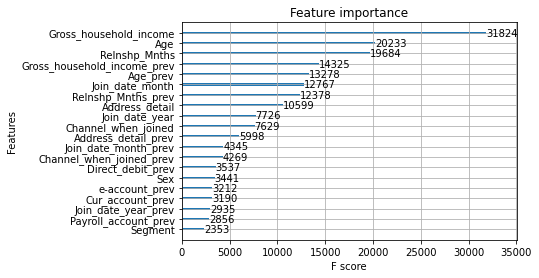

In [222]:
plot_importance(model, max_num_features = 20)
#plt.figure(figsize=(100,80))
figure.set_size_inches(100, 90)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.savefig('Features_imp.png')
plt.show()

NameError: name 'ax' is not defined

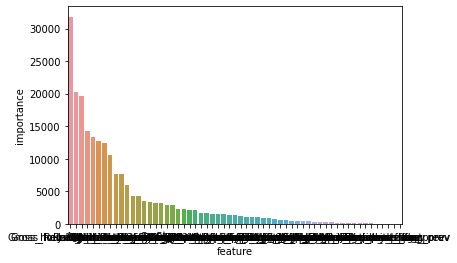

In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
feature_imp = pd.DataFrame(model.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)
sns.barplot(x=feature_imp.feature, y=feature_imp.importance)
# Add labels to your graph
fig = ax.figure
fig.set_size_inches(100, 90)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.savefig('Features_imp.png')